In [7]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [73]:
def load_batch(log_records, idx_offset=0):
    dat = pd.DataFrame()
    for path, label in log_records:
        d = pd.read_csv(path)
        d = d.set_index('iteration').rename(columns={'exploitability':label})
        dat = dat.join(d, how='outer')
    dat.index += idx_offset
    return dat

def log_interp(df, method="index"):
    df.index = df.index.map(np.log)
    df = df.apply(np.log)
    
    df = df.interpolate(method=method)
    
    df.index = df.index.map(np.exp)
    df = df.apply(np.exp)
    return df

# Figure 1
Convergence rates of XFP and ED algorithms on various partially-observable games in OpenSpiel. The units of the x-axis is iterations and the units of the y-axis is NashConv. Figure taken from [47]

[Text(0.5, 0, 'Iteration'), Text(0, 0.5, 'Exploitability')]

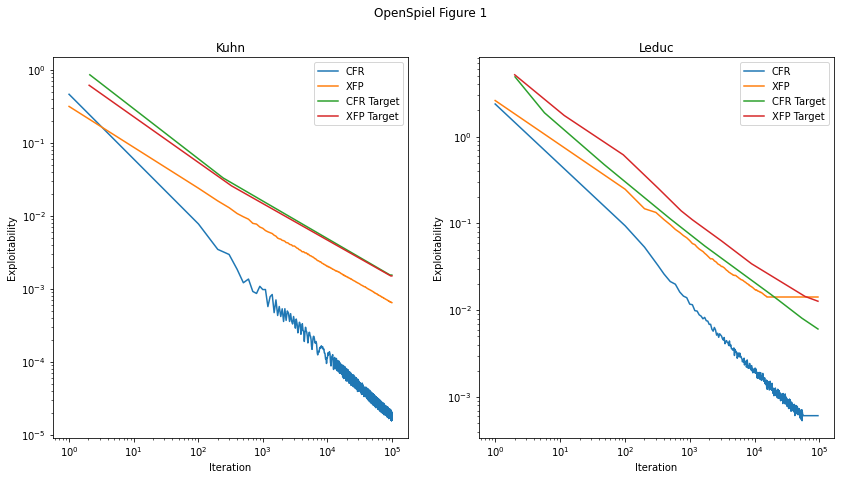

In [156]:
kuhn_logs = [("./logs/cfr_kuhn_1.csv", "CFR"),
             ("./logs/xfp_kuhn_0.csv", "XFP"),
             ("./target_results/fig1_cfr_kuhn.csv", "CFR Target"),
             ("./target_results/fig1_xfp_kuhn.csv", "XFP Target")
            ]

leduc_logs = [("./logs/cfr_leduc_2.csv", "CFR"),
              ("./logs/xfp_leduc_1.csv", "XFP"),
              ("./target_results/fig1_cfr_leduc.csv", "CFR Target"),
              ("./target_results/fig1_xfp_leduc.csv", "XFP Target")
            ]

kuhn_dat = log_interp(load_batch(kuhn_logs, idx_offset=1))
leduc_dat = log_interp(load_batch(leduc_logs, idx_offset=1))
# kuhn_dat["CFR Target"] /= 2
# kuhn_dat["XFP Target"] /= 2
# leduc_dat["CFR Target"] /= 2
# leduc_dat["XFP Target"] /= 2
#leduc_dat["CFR"] *= 2

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
fig.suptitle('OpenSpiel Figure 1')

ax = kuhn_dat.plot(title="Kuhn", logx=True, logy=True, ax=axes[0])
ax.set(xlabel="Iteration", ylabel="Exploitability")
#ax.set_xlim((1, 10e4))
#ax.set_ylim((10e-7, 1))

ax = leduc_dat.plot(title="Leduc", loglog=True, ax=axes[1])
ax.set(xlabel="Iteration", ylabel="Exploitability")
#ax.set_xlim((1, 10e4))
#ax.set_ylim((10e-4, 10))

# Figure 2
Convergence rate of RCFR in Leduc poker using a 2-layer network with 400 hidden units in each layer. The average policy is computed exactly (i.e. tabular), and regression targets are the
cumulative predicted regrets.

[Text(0.5, 0, 'Iteration'), Text(0, 0.5, 'Exploitability')]

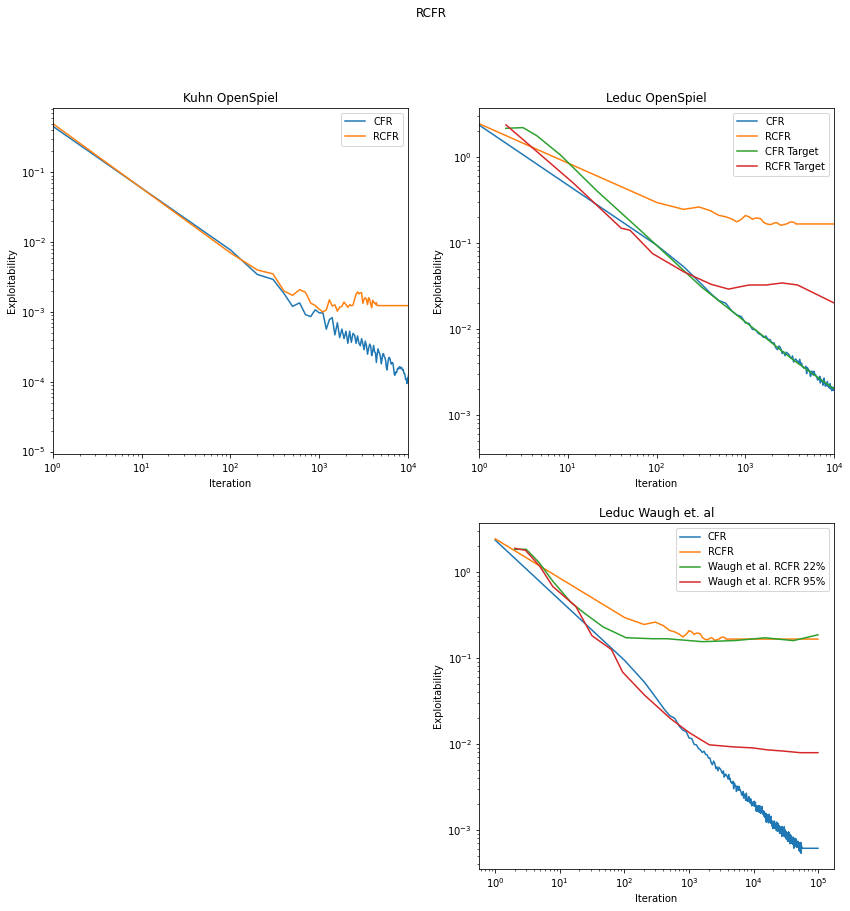

In [158]:
kuhn_logs = [("./logs/cfr_kuhn_1.csv", "CFR"),
             ("./logs/rcfr_kuhn_3.csv", "RCFR"),
            ]

leduc_logs = [("./logs/cfr_leduc_2.csv", "CFR"),
              ("./logs/rcfr_leduc_1.csv", "RCFR"),
              ("./target_results/fig2_cfr_leduc.csv", "CFR Target"),
              ("./target_results/fig2_rcfr_leduc.csv", "RCFR Target"),
              ("./target_results/rcfr_waugh_leduc_22.csv", "Waugh et al. RCFR 22%"),
              ("./target_results/rcfr_waugh_leduc_95.csv", "Waugh et al. RCFR 95%")
            ]

kuhn_dat = log_interp(load_batch(kuhn_logs, idx_offset=1))
leduc_dat = log_interp(load_batch(leduc_logs, idx_offset=1))

leduc_dat["Waugh et al. RCFR 22%"] *= .0001
leduc_dat["Waugh et al. RCFR 95%"] *= .0001
leduc_dat["CFR Target"] /= 2
leduc_dat["RCFR Target"] /= 2

log_log = True
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,14))
fig.suptitle('RCFR')
fig.delaxes(axes[1,0])

ax = kuhn_dat.plot(title="Kuhn OpenSpiel", logy=log_log, logx=log_log, ax=axes[0,0])
ax.set(xlabel="Iteration", ylabel="Exploitability")
ax.set_xlim((1, 10e3))

os_targets = ["CFR", "RCFR", "CFR Target", "RCFR Target"]
ax = leduc_dat[os_targets].plot(title="Leduc OpenSpiel", logy=log_log, logx=log_log, ax=axes[0,1])
ax.set(xlabel="Iteration", ylabel="Exploitability")
ax.set_xlim((1, 10e3))
#ax.set_ylim((10e-4, 10))

os_targets = ["CFR", "RCFR", "Waugh et al. RCFR 22%", "Waugh et al. RCFR 95%"]
ax = leduc_dat[os_targets].plot(title="Leduc Waugh et. al", logy=log_log, logx=log_log, ax=axes[1,1])
ax.set(xlabel="Iteration", ylabel="Exploitability")
#ax.set_xlim((1, 10e3))

# Figure 3
Convergence rates of NFSP and various (regret-based) policy gradient algorithms in 2-player Leduc poker. Each line is an __average over the top five seeds and hyperparemeter settings for each algorithm__. The lowest (around 0.2) exploitability value reached by any individual run is depicted by a dashed line.

In [152]:
leduc_dat.head()

,NFSP,NFSP Target,Heinrich Silver
iteration,,,
1.000000,2.328155,NaN,NaN
1001.000000,2.339418,NaN,2.023131
2775.481403,2.341086,NaN,1.805051
5479.180827,2.342198,NaN,1.480657
9871.023389,2.343161,NaN,1.028098


[Text(0.5, 0, 'Iteration'), Text(0, 0.5, 'Exploitability')]

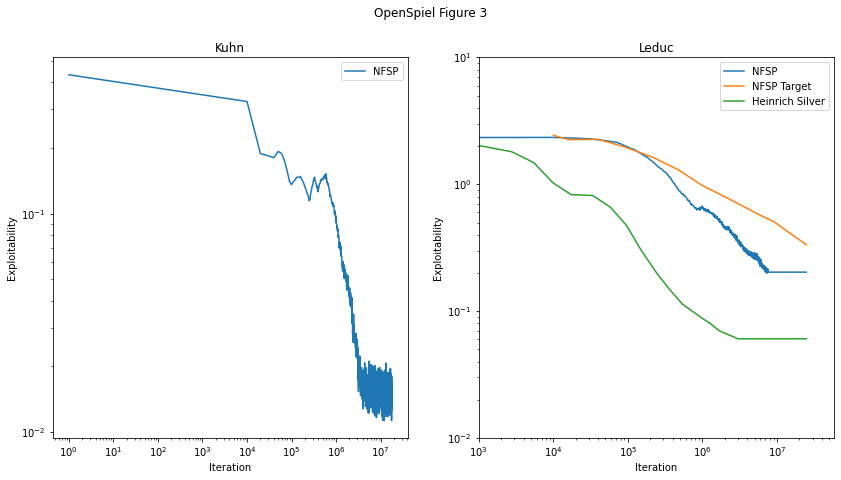

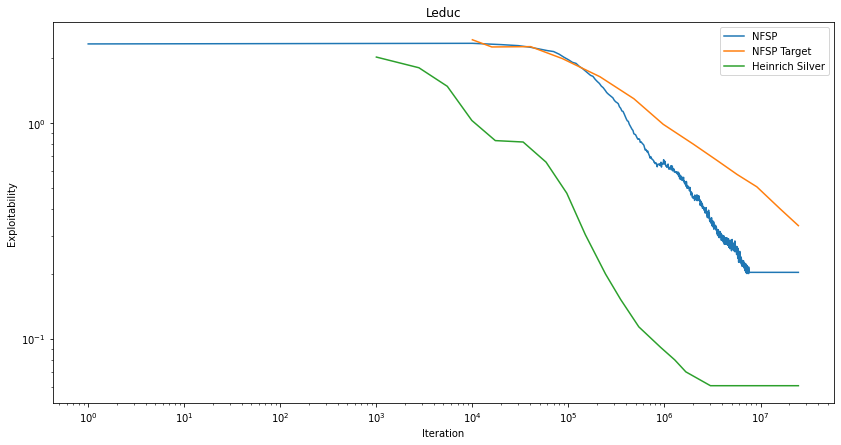

In [153]:
logx = True
logy = True

kuhn_logs = [("./logs/nfsp_kuhn_2.csv", "NFSP")
            ]

leduc_logs = [("./logs/nfsp_leduc_1.csv", "NFSP"),
              ("target_results/fig3_rcfr_leduc.csv", "NFSP Target"),
              ("target_results/nfsp_heinrich_silver_leduc_128.csv", "Heinrich Silver")
            ]

kuhn_dat = log_interp(load_batch(kuhn_logs, idx_offset=1)).dropna()
leduc_dat = log_interp(load_batch(leduc_logs, idx_offset=1))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
fig.suptitle('OpenSpiel Figure 3')

ax = kuhn_dat.plot(title="Kuhn", logx=logx, logy=logy, ax=axes[0])
ax.set(xlabel="Iteration", ylabel="Exploitability")

ax = leduc_dat.plot(title="Leduc", logx=logx, logy=logy, ax=axes[1])
ax.set(xlabel="Iteration", ylabel="Exploitability")
ax.set_ylim((.01, 10))
ax.set_xlim((1e3))

ax = leduc_dat.plot(title="Leduc", logx=True, logy=True, figsize=(14,7))
ax.set(xlabel="Iteration", ylabel="Exploitability")
#ax.set_ylim((.1, 3))

# -------------- Below results not reported in OpenSpiel Paper ---------

# DeepCFR

Text(0.5, 0.98, 'DeepCFR')

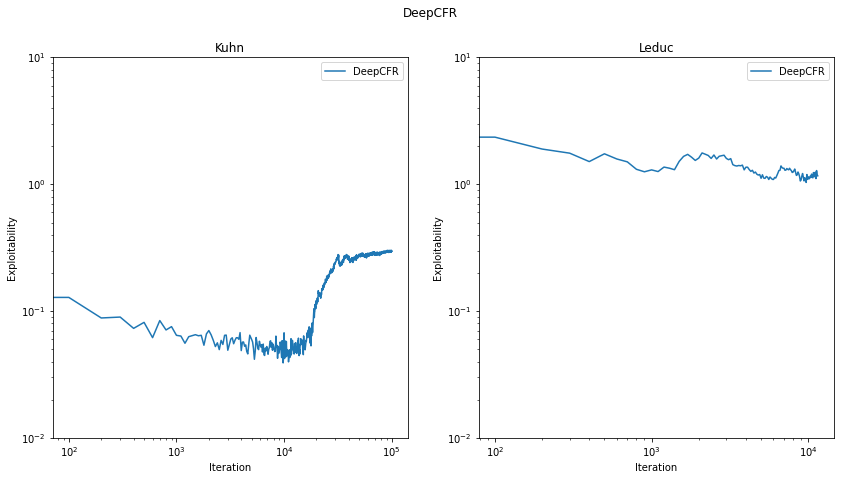

In [6]:
kuhn_logs = [("./logs/deep_cfr_kuhn_0.csv", "DeepCFR")
            ]

leduc_logs = [("./logs/deep_cfr_leduc_0.csv", "DeepCFR")
            ]

kuhn_dat = load_batch(kuhn_logs)
leduc_dat = load_batch(leduc_logs)

log_log = True
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
ax = kuhn_dat.plot(title="Kuhn", logy=log_log, logx=log_log, ax=axes[0])
ax.set(xlabel="Iteration", ylabel="Exploitability")
ax.set_ylim((.01, 10))
ax = leduc_dat.plot(title="Leduc", logy=log_log, logx=log_log, ax=axes[1])
ax.set(xlabel="Iteration", ylabel="Exploitability")
ax.set_ylim((.01, 10))
fig.suptitle('DeepCFR')

# PSRO